<a href="https://colab.research.google.com/github/alexmjn/NBA-Injuries/blob/master/NBA_Injuries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NBA Injuries

The unpredictable nature of injuries costs NBA teams millions of dollars each year (in addition to the cost in human suffering). (transition sentence) Have injury rates risen as the NBA has gotten more physically taxing? Did the 2011 NBA lockout affect injury rates for that season? Do different teams have different patterns of rest and injury? Using the NBA's published injury reports (sourced from Kaggle), I want to look at patterns and correlations within NBA injuries and rest.



#Import Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [0]:
url = "https://raw.githubusercontent.com/alexmjn/NBA-Injuries/master/injuries.csv"
df = pd.read_csv(url)

In [0]:
injuries = df.copy()

In [164]:
print(injuries.dtypes)
injuries.head()

Date           object
Team           object
Acquired       object
Relinquised    object
Notes          object
dtype: object


,Date,Team,Acquired,Relinquised,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Acchilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Pendergraph / Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


#Cleaning Data

The data contains four columns we're interested in: "Date," "Team," "Relinquised," (a column that shows what player suffered the injury), and "Notes," which is a brief text description of the injury.

"Acquired" is used to denote rows where a player returned from injury. Though there is likely interesting analysis to be done on players' time of recovery, from scanning the data, the "Acquired" columns were reported inconsistently within seasons and for various types of injuries; thus, this data is out of the scope of this analysis.

Therefore I drop rows which represent a return from injury and not an injury or rest and then drop the column itself.

In [0]:
injuries.columns = injuries.columns.str.lower()
injuries = injuries[injuries["acquired"].isnull() == True]
injuries = injuries.drop(["acquired"], axis = 1)
injuries.shape

In [168]:
injuries.dtypes

date           object
team           object
acquired       object
relinquised    object
notes          object
dtype: object

To perform operations on the "date" column, I cast it as a datetime object. To prevent mismatches due to case-sensitivity, I make all 'notes' lowercase. Finally, I clean the column name.

In [169]:
injuries["date"] = pd.to_datetime(injuries["date"], infer_datetime_format = True)
injuries["notes"] = injuries["notes"].apply(str.lower)
injuries = injuries.rename(columns={"relinquised":"player"})
injuries.head()

,date,team,player,notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,Jonas Jerebko,torn right acchilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,Jeff Pendergraph / Jeff Ayres,torn acl in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


Rest is inconsistently logged as either "DNP" or "Rest (DNP)". To ensure consistency, I log each as the former.

In [0]:
injuries["notes"] = injuries["notes"].replace({"dnp":"rest (dnp)"})

In [171]:
injuries["notes"].value_counts().head()

sprained left ankle (dnp)     362
rest (dtd)                    288
rest (dnp)                    191
sprained right ankle (dnp)    175
illness (dtd)                 149
Name: notes, dtype: int64

It's interesting that sprained left ankles are so much more common than sprained right ankles. I'm assuming this has something to do with biomechanics of right-footed players. Anyway, it's clear this is not perfect -- rest is logged as two different things -- but, since this column is for feature engineering, we don't have to worry about exact matches as long as they contain the right word. 

In [172]:
injuries.isnull().sum()

date      0
team      3
player    0
notes     0
dtype: int64

In [173]:
injuries[injuries["team"].isnull() == True]

,date,team,player,notes
6330,2015-09-02,NaN,Glen Davis,surgery on left ankle to repair torn ligaments...
6332,2015-09-03,NaN,Landry Fields,surgery on hip to repair torn labrum (out inde...
8349,2017-02-08,NaN,Dragan Bender,surgery on right ankle to remove bone spur (ou...


From research, I see that the NaN values here represent when a player had surgery while he was not under contract with a team (a free agent or had been waived). So I replace the missing values with "None".

In [0]:
injuries["team"] = injuries["team"].replace({np.NaN: "None"})

In [175]:
print(injuries.dtypes)
injuries.isnull().sum()

date      0
team      0
player    0
notes     0
dtype: int64

One issue with this dataset is the inconsistent logging of injuries over multiple days. For minor injuries, players will show up on the injury report for the same injury over multiple days or even weeks. However, for major injuries, the injury will be reported once and the player's absence will be assumed (they will be placed on the inactive list).

To ensure consistency, I decide that every row representing an injury will represent a discrete player injury. To do this, I sort the data by player and date and remove rows where the same player has the same injury reported within ten days of the last report. 

In [177]:
injuries = injuries.sort_values(by = ["player", "date"])
injuries.head()

,date,team,player,notes
501,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely)
630,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp)
777,2011-04-12,Spurs,(William) Tony Parker,rest (dnp)
1379,2012-02-21,Spurs,(William) Tony Parker,rest (dnp)
1645,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp)
1864,2012-04-09,Spurs,(William) Tony Parker,rest (dnp)
2347,2012-11-29,Spurs,(William) Tony Parker,rest (dnp)
2889,2013-02-11,Spurs,(William) Tony Parker,knee injury (dnp)
2930,2013-02-24,Spurs,(William) Tony Parker,sore triceps (dnp)
2963,2013-03-02,Spurs,(William) Tony Parker,sprained left ankle (out indefinitely)


In [0]:
# reset index for clean subsetting
injuries = injuries.reset_index(drop = True)

In [0]:
def same_player(i):
  return (df["player"][i] == df["player"][i-1])

def same_injury(i):
  return (df["notes"][i] == df["notes"][i-1])

def within_cutoff(i):
  return ((df["date"][i] - df["date"][i - 1]).days < 10)

def injury(i):
  return (("rest" in df["notes"][i]) == False)

In [0]:
def clean_injuries(df):
  redundant_rows = []

  for i in range(1, df.shape[0]):
    if same_player(i) & same_injury(i) & within_cutoff(i) & injury(i):
      redundant_rows.append(i)

  df = df.drop(redundant_rows)
  df = df.reset_index(drop = True)

  return df


In [180]:
cl_injuries = clean_injuries(injuries)
print(cl_injuries.shape)
cl_injuries.head(100)

(5482, 4)


,date,team,player,notes
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely)
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp)
2,2011-04-12,Spurs,(William) Tony Parker,rest (dnp)
3,2012-02-21,Spurs,(William) Tony Parker,rest (dnp)
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp)
...,...,...,...,...
95,2014-04-28,Bobcats,Al Jefferson,strained plantar fascia in left foot (dnp)
96,2014-12-31,Hornets,Al Jefferson,strained adductor muscle in left groin (out in...
97,2015-04-04,Hornets,Al Jefferson,sore right knee (out for season)
98,2015-11-30,Hornets,Al Jefferson,strained left calf (out indefinitely)


Looks like we got rid of the redundant injuries! Now every row represents (approximately) either a discrete injury or a voluntary day of rest.

#Feature Engineering

Now that the data set is cleaned, it's time to engineer some features so that we can analyze the data. I'll start by adding features that represent the month and year for each injury, so that I can analyze how injury and rest rates change throughout individual seasons and across the 

In [181]:
cl_injuries["month"] = (cl_injuries["date"].dt.month - 9) % 12 
cl_injuries["year"] = cl_injuries["date"].dt.year
cl_injuries.head(20)

,date,team,player,notes,month,year
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely),5,2011
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp),6,2011
2,2011-04-12,Spurs,(William) Tony Parker,rest (dnp),7,2011
3,2012-02-21,Spurs,(William) Tony Parker,rest (dnp),5,2012
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp),6,2012
5,2012-04-09,Spurs,(William) Tony Parker,rest (dnp),7,2012
6,2012-11-29,Spurs,(William) Tony Parker,rest (dnp),2,2012
7,2013-02-11,Spurs,(William) Tony Parker,knee injury (dnp),5,2013
8,2013-02-24,Spurs,(William) Tony Parker,sore triceps (dnp),5,2013
9,2013-03-02,Spurs,(William) Tony Parker,sprained left ankle (out indefinitely),6,2013


In [0]:
def season(date):
  if pd.Timestamp(2010, 10, 25, 12) < date < pd.Timestamp(2011, 4, 14, 12):
    return 2011
  elif pd.Timestamp(2011, 12, 24, 12) < date < pd.Timestamp(2012, 4, 27, 12):
    return 2012
  elif pd.Timestamp(2012, 10, 29, 12) < date < pd.Timestamp(2013, 4, 18, 12):
    return 2013
  elif pd.Timestamp(2013, 10, 28, 12) < date < pd.Timestamp(2014, 4, 17, 12):
    return 2014
  elif pd.Timestamp(2014, 10, 27, 12) < date < pd.Timestamp(2015, 4, 16, 12):
    return 2015
  elif pd.Timestamp(2015, 10, 26, 12) < date < pd.Timestamp(2016, 4, 14, 12):
    return 2016
  elif pd.Timestamp(2016, 10, 24, 12) < date < pd.Timestamp(2017, 4, 13, 12):
    return 2017
  elif pd.Timestamp(2017, 10, 16, 12) < date < pd.Timestamp(2018, 4, 12, 12):
    return 2018
  else: 
    return np.NaN

cl_injuries["season"] = cl_injuries["date"].apply(season)

# if time -- look at cleaning up this function (case switching)

In [0]:
cl_injuries = cl_injuries[cl_injuries["season"].isnull() == False]

In [184]:
cl_injuries["date"][0].day

28

In [0]:
start_2011 = pd.Timestamp(2010, 10, 25, 12)
start_2012 = pd.Timestamp(2011, 12, 24, 12)
start_2013 = pd.Timestamp(2012, 10, 29, 12)
start_2014 = pd.Timestamp(2013, 10, 28, 12)
start_2015 = pd.Timestamp(2014, 10, 27, 12)
start_2016 = pd.Timestamp(2015, 10, 26, 12)
start_2017 = pd.Timestamp(2016, 10, 24, 12)
start_2018 = pd.Timestamp(2017, 10, 16, 12)

In [0]:
def days_since_start(season, date):
  if season == 2011:
    return (date - start_2011).days
  elif season == 2012:
    return (date - start_2012).days
  elif season == 2013:
    return (date - start_2013).days
  elif season == 2014:
    return (date - start_2014).days
  elif season == 2015:
    return (date - start_2015).days
  elif season == 2016:
    return (date - start_2016).days
  elif season == 2017:
    return (date - start_2017).days
  elif season == 2018:
    return (date - start_2018).days
  

In [0]:
cl_injuries["days_since_start"] = cl_injuries.apply(lambda x: days_since_start(x.season, x.date), axis = 1)

In [214]:
cl_injuries["days_since_start_bin"] = pd.cut(cl_injuries["days_since_start"], 20, labels = False)
cl_injuries.head()

,date,team,player,notes,month,year,season,days_since_start,achilles,knee,foot,hand,ankle,back,hip,wrist,hamstring,quadriceps,neck,calf,thumb,elbow,shoulder,groin,concussion,finger,illness,days_since_start_bin
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely),5,2011,2011.0,125,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,14
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp),6,2011,2011.0,153,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp),6,2012,2012.0,89,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,10
7,2013-02-11,Spurs,(William) Tony Parker,knee injury (dnp),5,2013,2013.0,104,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,11
8,2013-02-24,Spurs,(William) Tony Parker,sore triceps (dnp),5,2013,2013.0,117,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,13


In [189]:
cl_injuries.isnull().sum()

date                0
team                0
player              0
notes               0
month               0
year                0
season              0
days_since_start    0
dtype: int64

Now that the data is clean at a baseline, we can get to analysis. For the remainder of the analysis, it'll be useful to separate rest -- which, after all, is not an injury -- with the actual injuries, such that inferences drawn on the data sets are conceptually valid.

In [0]:
rest = cl_injuries[cl_injuries["notes"].str.contains("rest") == True]
cl_injuries = cl_injuries[cl_injuries["notes"].str.contains("rest") == False].copy()

In [191]:
for word in ["achilles", "knee", "foot", "hand", "ankle", "back", "hip",
          "wrist", "hamstring", "quadriceps", "neck", "calf", "thumb",
          "elbow", "shoulder", "groin", "concussion", "finger"]:
          cl_injuries[word] = cl_injuries["notes"].str.contains(word)
cl_injuries.head()

,date,team,player,notes,month,year,season,days_since_start,achilles,knee,foot,hand,ankle,back,hip,wrist,hamstring,quadriceps,neck,calf,thumb,elbow,shoulder,groin,concussion,finger
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely),5,2011,2011.0,125,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp),6,2011,2011.0,153,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp),6,2012,2012.0,89,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,2013-02-11,Spurs,(William) Tony Parker,knee injury (dnp),5,2013,2013.0,104,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,2013-02-24,Spurs,(William) Tony Parker,sore triceps (dnp),5,2013,2013.0,117,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
illness = ["illness", "virus", "flu", "gastroenteritis", "stomach", "poisoning", "infection", "bronchitis"]

In [0]:
def test_string(word):
  return any(x in word for x in illness)

cl_injuries["illness"] = cl_injuries["notes"].apply(test_string)

In [194]:
cl_injuries.select_dtypes(include=['bool']).sum()

achilles       85
knee          880
foot          250
hand           70
ankle         767
back          349
hip           159
wrist         101
hamstring     184
quadriceps     39
neck           24
calf          131
thumb          62
elbow          62
shoulder      194
groin         127
concussion     80
finger         47
illness       452
dtype: int64

From looking at this, I think it might be more beneficial to group some of these.

#Analysis

To look at how injury rates have changed across seasons, I create a data frame of the sum of each type of injury grouped by season. I then scale the 2012 season to take into account the 2011 NBA lockout, reset the value of 2012 itself, and drop the columns that no longer make conceptual sense once summed.

In [0]:
seasons = cl_injuries.groupby("season", as_index = False).sum()
seasons.iloc[1] = round(seasons.iloc[1] * (82/66), 2) 
seasons["season"][1] = 2012
seasons = seasons.drop(["month", "year", "days_since_start"], axis = 1)

In [196]:
seasons.head(8)

,season,achilles,knee,foot,hand,ankle,back,hip,wrist,hamstring,quadriceps,neck,calf,thumb,elbow,shoulder,groin,concussion,finger,illness
0,2011.0,6.00,102.00,39.00,1.00,72.0,39.00,11.00,14.00,15.00,7.00,2.0,13.00,7.00,6.0,14.00,13.00,5.00,5.00,49.00
1,2012.0,14.91,119.27,38.52,4.97,123.0,60.88,18.64,11.18,24.85,6.21,0.0,17.39,4.97,8.7,33.55,37.27,16.15,6.21,62.12
2,2013.0,7.00,123.00,37.00,11.00,108.0,45.00,22.00,5.00,23.00,6.00,7.0,17.00,9.00,14.0,27.00,19.00,10.00,10.00,67.00
3,2014.0,9.00,143.00,38.00,14.00,110.0,53.00,14.00,15.00,31.00,4.00,4.0,21.00,5.00,7.0,19.00,13.00,2.00,5.00,65.00
4,2015.0,12.00,78.00,18.00,12.00,95.0,47.00,23.00,12.00,22.00,3.00,3.0,16.00,7.00,11.0,27.00,15.00,11.00,5.00,58.00
5,2016.0,12.00,115.00,32.00,6.00,82.0,53.00,26.00,10.00,24.00,4.00,2.0,16.00,9.00,4.0,37.00,12.00,14.00,7.00,61.00
6,2017.0,16.00,111.00,32.00,10.00,97.0,30.00,28.00,19.00,33.00,5.00,1.0,22.00,13.00,5.0,19.00,14.00,11.00,7.00,61.00
7,2018.0,11.00,112.00,23.00,12.00,104.0,33.00,20.00,17.00,16.00,5.00,5.0,12.00,8.00,8.0,24.00,11.00,14.00,3.00,41.00


In [197]:
seasonal_totals = pd.DataFrame(cl_injuries["season"].value_counts())
seasonal_totals = seasonal_totals.reset_index()
seasonal_totals.columns = ["season", "injuries"]
seasonal_totals = seasonal_totals.sort_values(by = "season")
seasonal_totals = seasonal_totals.reset_index(drop = True)
seasonal_totals.iloc[1, 1] = round((seasonal_totals.iloc[1,1] * 82/66), 2)
# function or variable to make legible lockout adjustment
seasonal_totals

,season,injuries
0,2011.0,457.00
1,2012.0,690.79
2,2013.0,595.00
3,2014.0,625.00
4,2015.0,540.00
5,2016.0,608.00
6,2017.0,585.00
7,2018.0,546.00


In [198]:
rest_totals = pd.DataFrame(rest["season"].value_counts())
rest_totals = rest_totals.reset_index()
rest_totals.columns = ["season", "days of rest"]
rest_totals = rest_totals.sort_values(by = "season")
rest_totals = rest_totals.reset_index(drop = True)
rest_totals.iloc[1, 1] = round((rest_totals.iloc[1,1] * 82/66), 2)
rest_totals

,season,days of rest
0,2011.0,33.00
1,2012.0,89.45
2,2013.0,31.00
3,2014.0,61.00
4,2015.0,65.00
5,2016.0,108.00
6,2017.0,130.00
7,2018.0,42.00


In [0]:
merged_seasons = seasonal_totals.merge(rest_totals, on = "season")

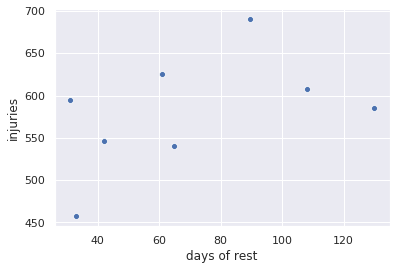

In [207]:
sns.scatterplot(x = merged_seasons["days of rest"], y = merged_seasons["injuries"])
plt.show()

In [216]:
binned_day_totals = pd.DataFrame(cl_injuries["days_since_start_bin"].value_counts())
binned_day_totals = binned_day_totals.reset_index()
binned_day_totals.columns = ["bin", "injuries"]
binned_day_totals = binned_day_totals.sort_values(by = "bin")
binned_day_totals = binned_day_totals.reset_index(drop = True)
binned_day_totals

# check for ASB, end of season. perhaps drop last row. check for statistical significance.

,bin,injuries
0,0,217
1,1,200
2,2,213
3,3,207
4,4,227
5,5,255
6,6,189
7,7,245
8,8,228
9,9,269


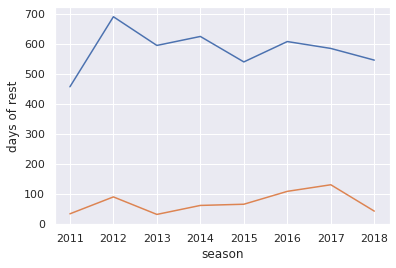

In [199]:
sns.set()
sns.lineplot(x = seasonal_totals["season"], y = seasonal_totals["injuries"])
sns.lineplot(x = rest_totals["season"], y = rest_totals["days of rest"])
plt.show()

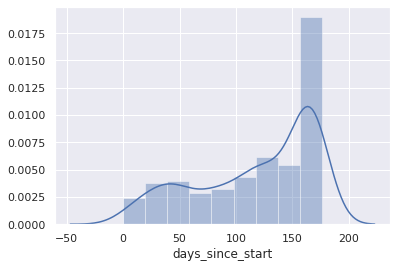

In [200]:
sns.distplot(rest["days_since_start"])
plt.show()
# Plots - add markdown explaining what to look for in the plot (whether interesting or unremarkable)

In [0]:
rest_teams = pd.DataFrame(rest["team"].value_counts()).reset_index()
rest_teams.columns = ["team", "days of rest"]

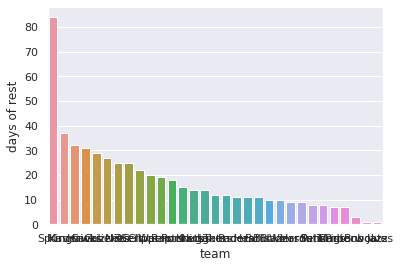

In [202]:
ax = sns.barplot(x = rest_teams["team"], y = rest_teams["days of rest"])
plt.show()
#drop label, explain in markdown

In [203]:
cl_injuries["month"].value_counts()
# definitely want to strip rest from this and do it by season
#frequency of different injuries by year. 
#perhaps simply strip out all offseason injuries so that 2010 and 2018 can be 
# compared on the same baseline. these are "procedures" not injuries.
# 2012 - lockout season - prorate

6    970
4    881
3    713
5    644
7    612
2    575
1    117
Name: month, dtype: int64

In [204]:
rest.head()

,date,team,player,notes,month,year,season,days_since_start
2,2011-04-12,Spurs,(William) Tony Parker,rest (dnp),7,2011,2011.0,168
3,2012-02-21,Spurs,(William) Tony Parker,rest (dnp),5,2012,2012.0,58
5,2012-04-09,Spurs,(William) Tony Parker,rest (dnp),7,2012,2012.0,106
6,2012-11-29,Spurs,(William) Tony Parker,rest (dnp),2,2012,2013.0,30
13,2014-02-12,Spurs,(William) Tony Parker,rest (dnp),5,2014,2014.0,106


In [205]:
just_injuries["player"].value_counts().head(10)

NameError: ignored

In [0]:
rest["player"].value_counts().head(10)

In [0]:
just_injuries["team"].value_counts()

In [0]:
rest["team"].value_counts()

In [0]:
sns.distplot(rest["season"])

In [0]:
rest["season"].value_counts()